# (Almost) 6 Months of Rust Runtime Performance

## From 2015-09-01 to 2016-02-11

### Update

### NOTE: The benchmarks are now normalized against the first result in each individual series. So a value of 1.0 means "roughly similar performance as the first measure in the series."

After some feedback on the reddit thread where I posted this, I've made a few changes here:

1. Posted the benchmark manifest and output json to https://github.com/dikaiosune/rust-runtime-benchmarks. Note that not all benchmarks in the manifest are included because they may have had all of their benchmarks ignored. secondstring doesn't have parameters to include which flags are called on `cargo bench` (yet).
2. I changed all of the graphs to use a more sensible y-axis. There's now a 50% window above and below the normalized values.
3. Fixed some typos.
4. Normalized all benchmark results against those from the first date the benchmark was successfully run (9/1/15 in most cases).
5. Set the same x axis for all graphs (9/1/15 - 2/11/16).

---

After reading [this issue](https://github.com/rust-lang/rust/issues/31265), I decided to poke around in the history of `rustc`'s runtime performance.

This data was generated using [secondstring](https://github.com/dikaiosune/secondstring), a benchmark tracking tool I'm working on (it's still pretty rudimentary right now). At the moment it only supports running specified crate versions and git repo commits against a range of nightly compiler dates. It doesn't have any analysis built-in and just saves some JSON of the results. Soon I'd like to add automatic regression detection, but for now I just wanted to do a little graphing of the data.

Using my completely 100% scientific method of benchmark selection (a combination of finding benchmarks among the most downloaded crates and searching crates.io for "benchmark"), I picked recent commits from ~20 repositories that support running `cargo bench` in their root directory and ran their benchmarks against nightly compilers from 9/1/15 to 2/11/16. The repositories' benchmarks were pinned to a single commit each, so this runs the same code across all of the compiler versions. All benchmarks were run on the same machine (i7-6700k) running Arch Linux.

I took the geometric mean of all benchmark functions for each day, and plotted them below. This should (although I'm certainly not a statistician) provide a performance index for each crate that varies independently of the relative benchmark times of functions (i.e. a 10% variation in a 1000ns function should affect the geometric mean about as much as a 10% variation in a 10ns function).

I'd be more than interested in hearing about a better way to reduce these benchmarks to a single index, as I'd eventually like to include a regression detector in secondstring. I had initially tried graphing each bench function separately, but that's hundreds of series and I just don't think it's practical.

Since I'm not terribly familiar with geometric means, I don't know what percentage variation in the index corresponds to in terms of actual performance. From the reading I've done, it seems like a 25% change in a single benchmark function would have a ~12% change in the index, which can be stacked multiple times for shifts in multiple bench functions.

In [4]:
%matplotlib inline
import datetime
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from scipy.stats.mstats import gmean

benches = {}

# process the JSON saved by secondstring
with open('example-benchmarks.json') as m:
    manifest_data = json.loads(''.join(m.readlines()))
    raw_benches = manifest_data['benches']
    for b in raw_benches:
        name = b['name']
        benches[name] = {}
        results = b['results']
        
        # for successful benchmarks, accumulate a list of all function average times
        for date, r in results.items():
            if r.get('Success', None) is not None:
                bench_run = r['Success']['times']
                for bench_fn in bench_run:
                    if date not in benches[name]:
                        benches[name][date] = []
                    
                    time = bench_run[bench_fn]['avg_time_ns']
                    benches[name][date].append(time)

In [5]:
def normalize_against_first(bench_results):
    tpls = [(d, avgs) for d, avgs in bench_results.items()]
    tpls = sorted(tpls)
    first = tpls[0]
    
    normalized = {}
    for date, avgs in bench_results.items():
        normalized[date] = [a / f for a, f in zip(avgs, first[1])]
    
    return normalized

In [6]:
# prep a pandas dataframe of each benchmark suite
def data_frame_for_benchmark(bench_results):
    # parse the dates and calculate the geometric mean
    bench_results = normalize_against_first(bench_results)
    bench_results = {datetime.datetime.strptime(d, '%Y-%m-%d'): np.array(v) for d, v in bench_results.items()}
    bench_results = {d: gmean(times) for d, times in bench_results.items()}
    
    # create a dataframe for plotting
    frame = pd.DataFrame.from_dict(bench_results, orient='index')
    if frame.size > 0:
        # sort by date
        frame = frame.sort_index()
        return frame
    else:
        # handle benchmarks that had all of their functions ignored
        return None

In [7]:
# plot a time series for a given benchmark
def plot_benchmark(bench_times):
    frame = data_frame_for_benchmark(bench_times)
    if frame is not None:
        plt.figure()
        frame.plot(legend=False)
        plt.ylim([0.5, 1.5])
        plt.xlim([datetime.datetime(2015, 9, 1), datetime.datetime(2016, 2, 11)])

## ahocorasick

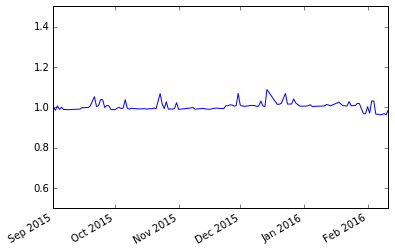

In [8]:
plot_benchmark(benches['ahocorasick'])

## byteorder

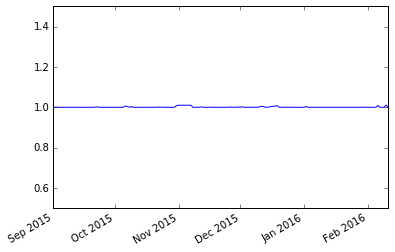

In [9]:
plot_benchmark(benches['byteorder'])

## cbor

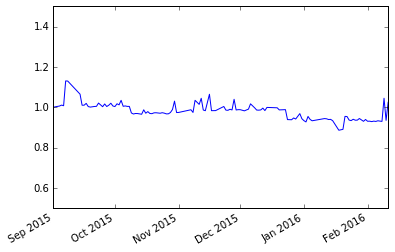

In [10]:
plot_benchmark(benches['cbor'])

## clap

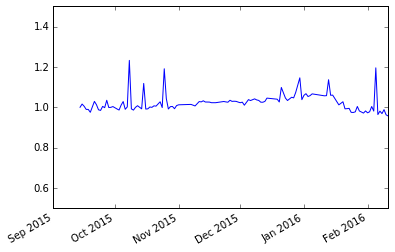

In [11]:
plot_benchmark(benches['clap'])

## crc

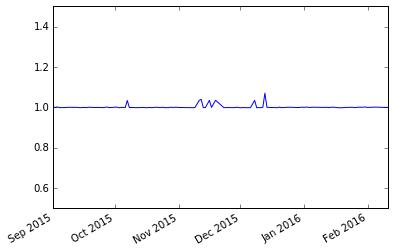

In [12]:
plot_benchmark(benches['crc'])

## csv

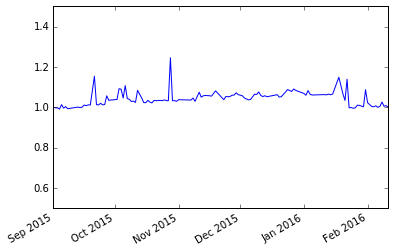

In [13]:
plot_benchmark(benches['csv'])

## hyper

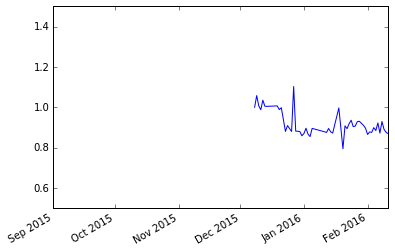

In [14]:
plot_benchmark(benches['hyper'])

## itertools

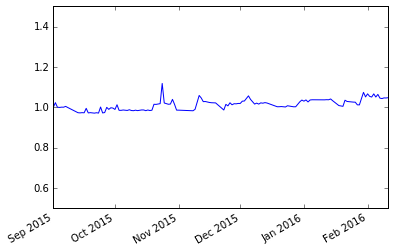

In [15]:
plot_benchmark(benches['itertools'])

## memchr

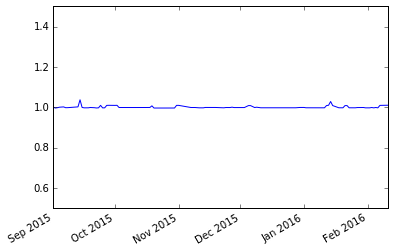

In [16]:
plot_benchmark(benches['memchr'])

## ndarray

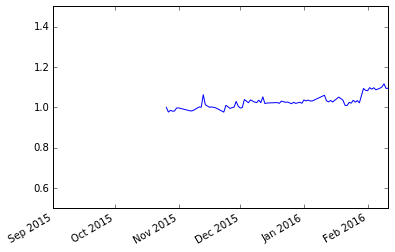

In [17]:
plot_benchmark(benches['ndarray'])

## num

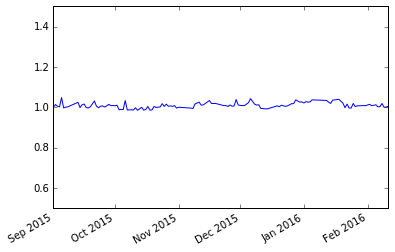

In [18]:
plot_benchmark(benches['num'])

## optional

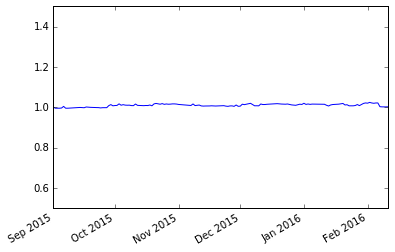

In [19]:
plot_benchmark(benches['optional'])

## permutohedron

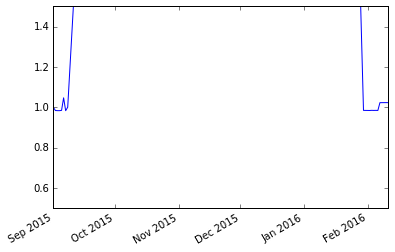

In [20]:
plot_benchmark(benches['permutohedron'])

## quickersort

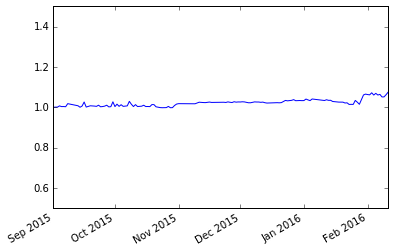

In [21]:
plot_benchmark(benches['quickersort'])

## rand

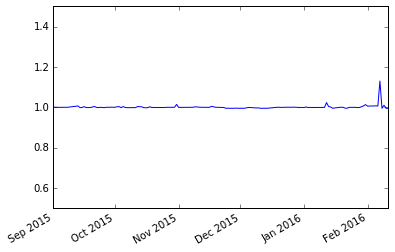

In [22]:
plot_benchmark(benches['rand'])

## rayon

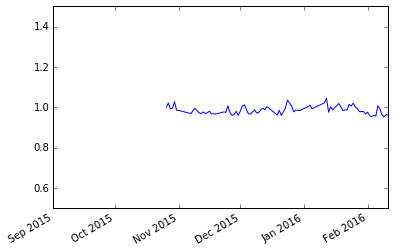

In [23]:
plot_benchmark(benches['rayon'])

## regex

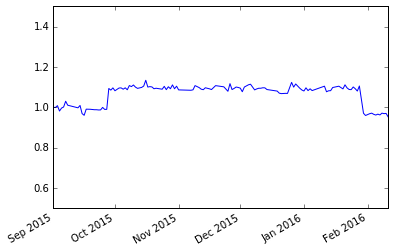

In [24]:
plot_benchmark(benches['regex'])

## simd

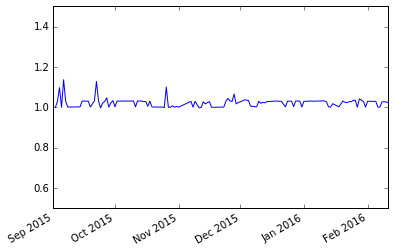

In [25]:
plot_benchmark(benches['simd'])

## suffix

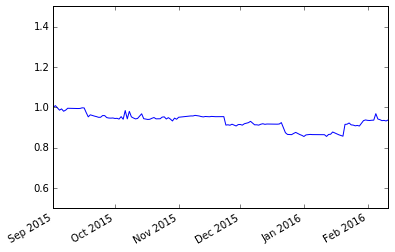

In [26]:
plot_benchmark(benches['suffix'])

## uuid

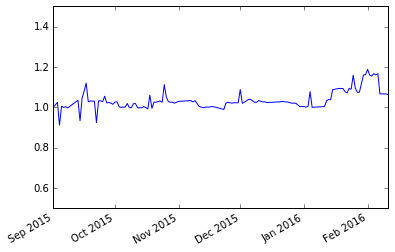

In [27]:
plot_benchmark(benches['uuid'])